[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/advanced_techniques/voyage_multimodal_3_5_video.ipynb)

# Getting started with voyage-multimodal-3.5

This notebook shows some of the ways you can use the latest [multimodal model](https://docs.voyageai.com/docs/multimodal-embeddings) from Voyage AI.

Let's dive in!

## 0. Obtain a Voyage API key

To run this notebook, you'll need a __Voyage API key__. If you don't have an API key yet, you can create one [here](https://dochub.mongodb.org/core/voyage-api-keys/#create-an-api-key).

## 1. Install packages

Now it's time to get started -- let's begin by installing some packages. For this notebook, you'll need:

- `voyageai` for calling accessing the multimodal model via the Voyage API
- `ffmpeg` for processing video files
- `ffmpeg-python`, a Python wrapper for `ffmpeg`

In [ ]:
!pip install -qU voyageai ffmpeg-python 

**If you're running this notebook in Google Colab**, run the following cell to install `ffmpeg`:

In [ ]:
!apt-get update -qq
!apt-get install -y ffmpeg

**If you're running this notebook locally**, do the following:

1. Install `ffmpeg` from the terminal based on the OS you are using.
#### MacOS

```
brew install ffmpeg
```

#### Linux

```
sudo apt-get install ffmpeg
```

#### Windows
* Download the executable from [ffmpeg.org](https://ffmpeg.org/download.html#build-windows)
* Extract the downloaded zip file
* Note the path to the `bin` folder

2. Ensure that `ffmpeg` is accessible from your notebook. To do this, uncomment the cell below and replace `/path/to/ffmpeg` with your `ffmpeg` path:

In [6]:
# import os

# os.environ["PATH"] = f"/path/to/ffmpeg:{os.environ['PATH']}"

For this notebook, we'll use `voyage-multimodal-3.5` as the embedding model. You can see a full list of multimodal embedding models available to you in the [our documentation](https://dochub.mongodb.org/core/voyage-multimodal-embeddings).

In [7]:
MODEL_NAME = "voyage-multimodal-3.5"

## 2. Create a synchronous Voyage client

Paste your Voyage API key when prompted upon running the cell below:

In [8]:
import getpass
import os

api_key = getpass.getpass("Enter your Voyage API key:")

Enter your VoyageAI API key: ········


In [48]:
from voyageai import Client

vo = Client(api_key=api_key)

## 3. Generate some vectors over example data

`voyage-multimodal-3.5` can embed interleaved text and visual inputs, including videos. 

Let's assume we have a video, its description, and frames extracted from it. Let's see how to embed the following using `voyage-multimodal-3.5`:

1. Video only
2. Individual frames only
3. Video description only
4. Video and its description
5. A frame and its description 

In [13]:
text = "Picking cilantro leaves from their stems."

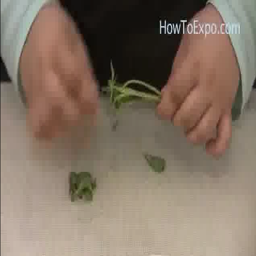

In [14]:
import urllib.request
from io import BytesIO

from PIL import Image

# Download the frame
with urllib.request.urlopen(
    "https://genai-tutorials.s3.us-west-2.amazonaws.com/voyage-multimodal-3-5/example_frame.png"
) as f:
    data = BytesIO(f.read())
frame = Image.open(data).resize((256, 256))
frame

In [15]:
# Download the video to an in-memory buffer
with urllib.request.urlopen(
    "https://genai-tutorials.s3.us-west-2.amazonaws.com/voyage-multimodal-3-5/example_video.mp4"
) as response:
    video_buffer = BytesIO(response.read())

The `multimodal_embed` method accepts video inputs as `Video` objects. You can create these using the `Video` class from the `voyageai` library:

In [16]:
from voyageai.video_utils import Video

video = Video.from_file(file_obj=video_buffer, model=MODEL_NAME)

client_config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

In the above example, we created the `Video` object from a file-like object/bytes, but you can also create it from a local filesystem path using the `from_path` method.

Now let's compile the documents to embed. 

In [17]:
documents = [
    [video],  # 1. Video only
    [frame],  # 2. Individual frame only
    [text],  # 3. Video description only
    [video, text],  # 4. Video and its description
    [text, frame],  # 5. Frame and its description
]

In [18]:
result = vo.multimodal_embed(inputs=documents, model=MODEL_NAME, input_type="document")

A call to the `multimodal_embed` function returns a `MultimodalEmbeddings` dataclass, which contains five components:

- `.embeddings`: The computed vectors
- `.text_tokens`: The number of text tokens ingested across all inputs
- `.image_pixels`: The number of image pixels processed across all inputs
- `.video_pixels`: The number of video pixels processed across all inputs
- `.total_tokens`: The total token count when images are taken into consideration (one image token is 560 pixels, one video token is 1120 pixels). Keep in mind that each input must not exceed 32,000 tokens, and the total number of tokens across all inputs must not exceed 320,000.

We can see the results here across all our documents:

In [19]:
print(f"Number of vectors generated: {len(result.embeddings)}")
print(f"Number of text tokens ingested: {result.text_tokens}")
print(f"Number of image pixels processed: {result.image_pixels}")
print(f"Number of video pixels processed: {result.video_pixels}")
print(f"Total number of tokens (texts + images + video): {result.total_tokens}")

Number of vectors generated: 5
Number of text tokens ingested: 25
Number of image pixels processed: 131072
Number of video pixels processed: 30005248
Total number of tokens (texts + images + video): 27049


To query these documents using say vector search, set the `input_type` to `"query"` when embedding the search query.

In [20]:
query = "Plucking herbs with hands"

In [21]:
query_embedding = vo.multimodal_embed(
    inputs=[[query]], model=MODEL_NAME, input_type="query"
).embeddings[0]

For the rest of this tutorial, we will focus mainly on video inputs. For more examples of how to embed other input types using `voyage-multimodal-3.5`, refer to the [voyage-multimodal-3 tutorial](https://github.com/mongodb-developer/GenAI-Showcase/blob/main/notebooks/quickstarts/voyage_multimodal_3.ipynb). Both models use the `multimodal_embed` method of the API and support the same input formats, with the exception that `voyage-multimodal-3.5` supports video inputs.

## 4. Video optimization

In the previous example, we embedded a short (32-second) low-resolution video that was well within the model's 32,000 token and 20 MB file-size limits. However, in the real world, you'll likely encounter longer videos, with different resolutions, frame rates, etc., which will oftentimes exceed these limits. Let's see how to handle such inputs when working with `voyage-multimodal-3.5`.


By default, videos are automatically optimized when creating `Video` objects for vectorization using the `voyageai` library. This is done by setting the `optimize` parameter to `True` when calling the `from_file` and `from_path` methods.

Optimization here mainly means resizing the videos and downsampling the frame rate to ensure videos stay within the model's token limits. The complete optimization logic can be found [here](https://github.com/voyage-ai/voyageai-python/blob/main/voyageai/video_utils.py#L394). 

To test this, let's use a video that we know exceeds the model's limits:

In [22]:
with urllib.request.urlopen(
    "https://genai-tutorials.s3.us-west-2.amazonaws.com/voyage-multimodal-3-5/nasa_video.mp4"
) as response:
    video_buffer = BytesIO(response.read())

Let's get stats like the frame rate, number of pixels, estimated token usage, etc., for the video prior to optimization using `ffmpeg`.

But first, we need to save the video bytes to a temporary file: 

In [23]:
import tempfile

import ffmpeg

data = video_buffer.read()
temp_file = tempfile.NamedTemporaryFile(suffix=".mp4", delete=False)
temp_file.write(data)
temp_file.flush()
temp_path = temp_file.name
temp_file.close()

Now let's use the `probe` method of `ffmpeg` to extract metadata from the video:

In [24]:
probe = ffmpeg.probe(temp_path)
video_stream = next(
    (s for s in probe["streams"] if s.get("codec_type") == "video"),
    None,
)

In [25]:
width = int(video_stream["width"])
height = int(video_stream["height"])
num_frames = int(video_stream.get("nb_frames", 0))
frame_rate = video_stream.get("r_frame_rate", "0/0")
duration = float(video_stream.get("duration", 0))
pixels_per_frame = width * height
num_pixels = pixels_per_frame * num_frames
estimated_tokens = int(num_pixels / 1120)

The stats for the video before optimization are as follows:

In [26]:
print(f"Width of each frame: {width}")
print(f"Height of each frame: {height}")
print(f"Number of frames: {num_frames}")
print(f"Frame rate: {frame_rate}")
print(f"Video duration (seconds): {duration}")
print(f"Pixels per frame: {pixels_per_frame}")
print(f"Total video pixels: {num_pixels}")
print(f"Estimated token usage: {estimated_tokens}")

Width of each frame: 1920
Height of each frame: 1080
Number of frames: 6654
Frame rate: 60/1
Video duration (seconds): 110.9
Pixels per frame: 2073600
Total video pixels: 13797734400
Estimated token usage: 12319405


As seen above, the video in its original form would consume ~12.3M tokens, exceeding the model's 32K token limit by nearly 400x. The video is in full HD resolution (1920 x 1080) with a high frame rate of 60 fps, both of which can be reduced significantly to optimize token consumption.

Now let's create the `Video` object with optimization enabled by default:

In [27]:
video = Video.from_path(path=temp_path, model=MODEL_NAME)

In [28]:
# Verify that video optimization is turned on
video.optimized

True

In [29]:
# Number of video pixels after optimization
video.num_pixels

32000000

In [30]:
# Number of frames after optimization
video.num_frames

16

In [31]:
# Estimated token usage after optimization
video.estimated_num_tokens

28571

As seen above, the optimizer downsampled the frame rate to strategically capture 16 frames across the entire video, while largely retaining the frame resolution.

This aggressive frame sampling is effective because consecutive frames at high frame rates (like 60 fps) are often visually redundant and don't add new semantic information. Maintaining higher frame resolution, however, preserves the visual details and clarity needed for accurate content understanding, that lower resolutions might lose.

## 5. Semantic video segmentation

In some cases, you might want more control over how frames are selected rather than relying on auto-sampling, especially for longer videos. In such scenarios, you may first want to split the videos into smaller segments and embed each segment separately.

For example, if you have video transcripts/captions, splitting the video based on natural breaks in the transcripts will ensure that related frames stay together, resulting in more focused embeddings. If segments still exceed the 32K token limit, you can apply auto-optimization on top of your initial semantic segmentation for best results.

Let's see how to do this. We'll use the same video as in Section 4a, along with its captions.

In [33]:
import json

# Load captions
with urllib.request.urlopen(
    "https://genai-tutorials.s3.us-west-2.amazonaws.com/voyage-multimodal-3-5/captions.json"
) as response:
    captions = json.loads(response.read())

Caption files typically contain timestamped segments of dialogue or narration from a video. Each entry includes start and end times and the corresponding text for the segment.

An example of an entry in our caption file is as follows:

In [34]:
captions[0]

{'start': 0.0,
 'end': 7.166,
 'text': 'A fresh take on the origin of Earth’s Moon '}

Now, let's use `ffmpeg` to split the video based on the caption timestamps.

In [43]:
import os

# Create directory to store video segments
segments_dir = "./video_segments"
os.makedirs(segments_dir, exist_ok=True)

In [44]:
for i, caption in enumerate(captions):
    output_file = os.path.join(segments_dir, f"segment_{i:03d}.mp4")
    (
        ffmpeg.input(temp_path, ss=caption["start"], to=caption["end"])
        .output(output_file, c="copy")
        .overwrite_output()
        .run(quiet=True)
    )

    print(f"Created {output_file}: {caption['start']:.3f}s - {caption['end']:.3f}s")

Created ./video_segments/segment_000.mp4: 0.000s - 7.166s
Created ./video_segments/segment_001.mp4: 9.383s - 16.550s
Created ./video_segments/segment_002.mp4: 18.533s - 25.700s
Created ./video_segments/segment_003.mp4: 31.333s - 38.500s
Created ./video_segments/segment_004.mp4: 40.900s - 48.366s
Created ./video_segments/segment_005.mp4: 53.016s - 60.533s
Created ./video_segments/segment_006.mp4: 64.233s - 70.066s
Created ./video_segments/segment_007.mp4: 72.500s - 79.916s
Created ./video_segments/segment_008.mp4: 83.066s - 90.333s
Created ./video_segments/segment_009.mp4: 92.633s - 99.800s


Let's convert each video segment into a `Video` object:

In [45]:
videos = []
for file_name in os.listdir(segments_dir):
    file_path = os.path.join(segments_dir, file_name)
    video = Video.from_path(path=file_path, model=MODEL_NAME)
    videos.append([video])

Note that the video segments are auto-optimized by default to stay within the model's token limits. Segmenting by captions ensures related frames stay together, and the optimization removes any redundant frames.

Now, let's vectorize each video segment separately:

In [49]:
embeddings = vo.multimodal_embed(
    inputs=videos, model=MODEL_NAME, input_type="document"
).embeddings
print(f"Number of vectors generated: {len(embeddings)}")

Number of vectors generated: 10


You can also embed the video segments along with their captions to create more contextually aware embeddings:

In [50]:
sorted_segments = sorted([f for f in os.listdir(segments_dir)])

# Create video-caption pairs
videos_with_captions = []
for i, file_name in enumerate(sorted_segments):
    file_path = os.path.join(segments_dir, file_name)
    video = Video.from_path(path=file_path, model=MODEL_NAME)
    videos_with_captions.append([video, captions[i]["text"]])

print(f"Example input: {videos_with_captions[0]}")

# Embed videos along with their captions
embeddings = vo.multimodal_embed(
    inputs=videos_with_captions, model=MODEL_NAME, input_type="document"
).embeddings
print(f"Number of vectors generated: {len(embeddings)}")

Example input: [<voyageai.video_utils.Video object at 0x7f3c002aec20>, 'A fresh take on the origin of Earth’s Moon ']
Number of vectors generated: 10


# Next steps

Try `voyage-multimodal-3.5` on your own data today! The first 200M tokens are on us. If you have any follow-up questions, or if you're interested in fine-tuned embeddings, feel free to reach out to use at contact@voyageai.com.

Feel free to follow us on [X (Twitter)](https://x.com/VoyageAI) and [LinkedIn](https://www.linkedin.com/company/voyageai/), and join our [Discord](https://discord.gg/zAU7GQEmvT) for more updates.